## Topic Modelling (LDA - Gensim LDA Mallet) & Content Base Recommendation (LDA + TF-IDF)

In [13]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
import langid


#plot
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [14]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Import datafiles

In [15]:
import glob

path = r'./dataSmall/' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)


df = frame
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,34,Find out what happens when Albert decides to p...,"{""id"":46,""name"":""Children's Books"",""slug"":""pub...",843,US,the United States,1564969508,"{""id"":1185753820,""name"":""Kelly Airhart"",""slug""...",USD,$,...,alberts-cookie-a-childrens-book,https://www.kickstarter.com/discover/categorie...,True,False,successful,1567632714,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",843.000000,international
1,25,Following the success of our Hastings and St L...,"{""id"":349,""name"":""Letterpress"",""slug"":""publish...",873,GB,the United Kingdom,1498480246,"{""id"":2133715710,""name"":""EEK Publications"",""sl...",GBP,£,...,sneeky-peek-presents-a-picturesque-guide-book-...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1507617030,1.319919,"{""web"":{""project"":""https://www.kickstarter.com...",876.426502,international
2,8,Join us on this amazing journey to impacting 1...,"{""id"":49,""name"":""Periodicals"",""slug"":""publishi...",234,AU,Australia,1437294575,"{""id"":124148187,""name"":""Brenda van Rensburg"",""...",AUD,$,...,reaching-the-stars-with-spacetripreneurs,https://www.kickstarter.com/discover/categorie...,False,False,failed,1439893575,0.737314,"{""web"":{""project"":""https://www.kickstarter.com...",234.465725,international
3,512,An anthology of queer witchery.,"{""id"":324,""name"":""Anthologies"",""slug"":""publish...",18131,US,the United States,1605839241,"{""id"":154688021,""name"":""dave ring"",""slug"":""dav...",USD,$,...,unfettered-hexes-queer-tales-of-insatiable-dar...,https://www.kickstarter.com/discover/categorie...,True,True,successful,1609509126,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",18131.000000,international
4,0,"Written by a chronically ill girl, commenting ...","{""id"":50,""name"":""Poetry"",""slug"":""publishing/po...",0,US,the United States,1462053258,"{""id"":514222826,""name"":""Moriah Rabeaux"",""is_re...",USD,$,...,walking-into-winter-writing-to-warm-the-frostb...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1464816474,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000,international


In [16]:
# use langid lib to do language detection remove non-english
df['language'] = df['blurb'].apply(lambda x: langid.classify(x)[0])
df = df[df['language'] == 'en']

In [17]:
#Pre-process, stopwords, lemmatization, etc
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)
df['blurb']=df['blurb'].map(lambda s:preprocess(s)) 

<ipython-input-17-7c28d2e47646>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blurb']=df['blurb'].map(lambda s:preprocess(s))


In [18]:
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,...,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,language
0,34,find happens albert decides play food takes hi...,"{""id"":46,""name"":""Children's Books"",""slug"":""pub...",843,US,the United States,1564969508,"{""id"":1185753820,""name"":""Kelly Airhart"",""slug""...",USD,$,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1567632714,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",843.000000,international,en
1,25,following success hastings leonard guide book ...,"{""id"":349,""name"":""Letterpress"",""slug"":""publish...",873,GB,the United Kingdom,1498480246,"{""id"":2133715710,""name"":""EEK Publications"",""sl...",GBP,£,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1507617030,1.319919,"{""web"":{""project"":""https://www.kickstarter.com...",876.426502,international,en
2,8,join amazing journey impacting million children,"{""id"":49,""name"":""Periodicals"",""slug"":""publishi...",234,AU,Australia,1437294575,"{""id"":124148187,""name"":""Brenda van Rensburg"",""...",AUD,$,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1439893575,0.737314,"{""web"":{""project"":""https://www.kickstarter.com...",234.465725,international,en
3,512,anthology queer witchery,"{""id"":324,""name"":""Anthologies"",""slug"":""publish...",18131,US,the United States,1605839241,"{""id"":154688021,""name"":""dave ring"",""slug"":""dav...",USD,$,...,https://www.kickstarter.com/discover/categorie...,True,True,successful,1609509126,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",18131.000000,international,en
4,0,written chronically ill girl commenting ups do...,"{""id"":50,""name"":""Poetry"",""slug"":""publishing/po...",0,US,the United States,1462053258,"{""id"":514222826,""name"":""Moriah Rabeaux"",""is_re...",USD,$,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1464816474,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000,international,en


In [19]:
#Only keep relevant cols
tempData = df[['name','category','blurb']]
df = df[['name','category','blurb']]

In [20]:
#Extract category out of json
def extract_cat(text):
    text = text.split(",")
    
    text = text[1] + " " +text[2]
    text = text.replace ("/", ",")
    
    
    text = text.replace ("name", "")
    text = text.replace ("slug", "")
    
    text = text.replace ('"', "")
    text = text.replace ('{', "")
    text = text.replace (':', "")
    
    text = text.lower()
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text) # matches all whitespace characters
    text = text.strip(' ')
    
    text = text.split(",")
    if len(text)== 3:
        return text[0] + ',' + text[1]
    elif len(text) == 2:
        return text[0] + ',' + text[1]
    elif len(text) == 1:
        return text[0]
    return ''



df['category'] = df['category'].apply(lambda x: extract_cat(x))

df = df[['name','category','blurb']]
df.head()

,name,category,blurb
0,Albert's Cookie- A Children's Book,"children's books publishing,children's books",find happens albert decides play food takes hi...
1,SNEEKY PEEK presents a Picturesque Guide Book ...,"letterpress publishing,letterpress",following success hastings leonard guide book ...
2,REACHING the STARS with SpaceTripreneurs,"periodicals publishing,periodicals",join amazing journey impacting million children
3,Unfettered Hexes: Queer Tales of Insatiable Da...,"anthologies publishing,anthologies",anthology queer witchery
4,Walking Into Winter: Writing to Warm the Frost...,"poetry publishing,poetry",written chronically ill girl commenting ups do...


In [26]:
# Convert to list
data = df.blurb.values.tolist()

pprint(data[:1])


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

['find happens albert decides play food takes high flying adventure outer '
 'space']
[['find', 'happens', 'albert', 'decides', 'play', 'food', 'takes', 'high', 'flying', 'adventure', 'outer', 'space']]


In [27]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['find', 'happens', 'albert', 'decides', 'play', 'food', 'takes', 'high', 'flying', 'adventure', 'outer', 'space']


In [28]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [29]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['find', 'happen', 'albert', 'decide', 'play', 'food', 'take', 'high', 'flying', 'adventure', 'outer', 'space']]


In [30]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


In [31]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('adventure', 1),
  ('albert', 1),
  ('decide', 1),
  ('find', 1),
  ('flying', 1),
  ('food', 1),
  ('happen', 1),
  ('high', 1),
  ('outer', 1),
  ('play', 1),
  ('space', 1),
  ('take', 1)]]

### Import pre-trained LDA Model

In [32]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
from gensim.models.wrappers import LdaMallet


In [33]:
# ldamallet already trained
import pickle
# pickle.dump(ldamallet, open("picke", "wb"))
ldamallet = pickle.load(open("picke", "rb"))

### Show Topics

In [36]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(13,
  [('film', 0.18948126801152737),
   ('short', 0.069164265129683),
   ('feature', 0.06592219020172911),
   ('horror', 0.059077809798270896),
   ('movie', 0.05223342939481268),
   ('animate', 0.029178674351585013),
   ('documentary', 0.026657060518731988),
   ('short_film', 0.023054755043227664),
   ('animation', 0.018731988472622477),
   ('thriller', 0.018011527377521614)]),
 (37,
  [('music', 0.15304067660088602),
   ('video', 0.1401530406766009),
   ('produce', 0.04470398711236408),
   ('sound', 0.03987112364075715),
   ('create', 0.037857430527587596),
   ('single', 0.03745469190495369),
   ('professional', 0.031413612565445025),
   ('producer', 0.022956101490132903),
   ('electronic', 0.022553362867498993),
   ('happy', 0.01973419250906162)]),
 (30,
  [('school', 0.05584997961679576),
   ('run', 0.052588666938442725),
   ('student', 0.027721157766000815),
   ('kit', 0.025275173257236036),
   ('innovative', 0.02405218100285365),
   ('support', 0.02242152466367713),
   ('exciti

In [35]:
tm_results = ldamallet[corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

In [37]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 41,Topic 42,Topic 43,Topic 44,Topic 45,Topic 46,Topic 47,Topic 48,Topic 49,Topic 50
Term1,love,open,make,life,live,app,join,world,back,system,...,food,create,child,coffee,young,good,community,art,book,unique
Term2,family,style,dream,bring,podcast,power,friend,explore,city,tool,...,restaurant,base,fun,craft,follow,online,build,artist,comic,card
Term3,find,hope,unique,change,american,easy,group,high,bring,nature,...,serve,goal,learn,shop,girl,website,local,feature,write,deck
Term4,friend,house,jewelry,find,lose,device,fight,war,team,earth,...,healthy,grow,kid,move,man,medium,provide,creative,publish,custom
Term5,home,building,piece,leave,death,build,discover,journey,sport,clean,...,market,line,age,bar,short_film,news,farm,female,page,limited_edition


In [38]:
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df


<ipython-input-38-22448409583d>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"love, family, find, friend, home, share, fall, story, people, spread, loss, queer, friendship, message, joy, romance, teenager, fuel, laugh, result"
Topic2,"open, style, hope, house, building, state, memory, ready, deliver, large, pizza, bakery, door, stop, cut, historic, upgrade, close, fire, location"
Topic3,"make, dream, unique, jewelry, piece, handmade, usa, glass, wearable, bracelet, soap, simple, sign, case, necklace, jewellery, come_true, overcome, wheel, crystal"
Topic4,"life, bring, change, find, leave, fill, idea, century, dead, forever, bird, start, extraordinary, experience, moment, famous, legacy, happiness, worth, finally"
Topic5,"live, podcast, american, lose, death, country, guy, mother, talk, father, son, host, brother, blog, teen, political, exist, fear, interview, cultural"
Topic6,"app, power, easy, device, build, smart, control, phone, camera, screen, user, portable, charge, pro, connect, smartphone, android, station, application, fitness"
Topic7,"join, friend, group, fight, discover, bad, seek, escape, turn, dark, web_serie, protect, force, mystery, evil, forest, trip, murder, hunt, mysterious"
Topic8,"world, explore, high, war, journey, technology, legend, deep, energy, combine, tech, crazy, view, mile, wide, myth, japan, advanced, speed, renowned"
Topic9,"back, city, bring, team, sport, put, west, heart, passion, side, europe, musical, middle, street, drive, van, village, popular, ghost, center"
Topic10,"system, tool, nature, earth, clean, simple, everyday, care, cool, solution, plastic, planet, key, skin, beach, knife, carry, problem, choice, green"


### Visualizations of topics

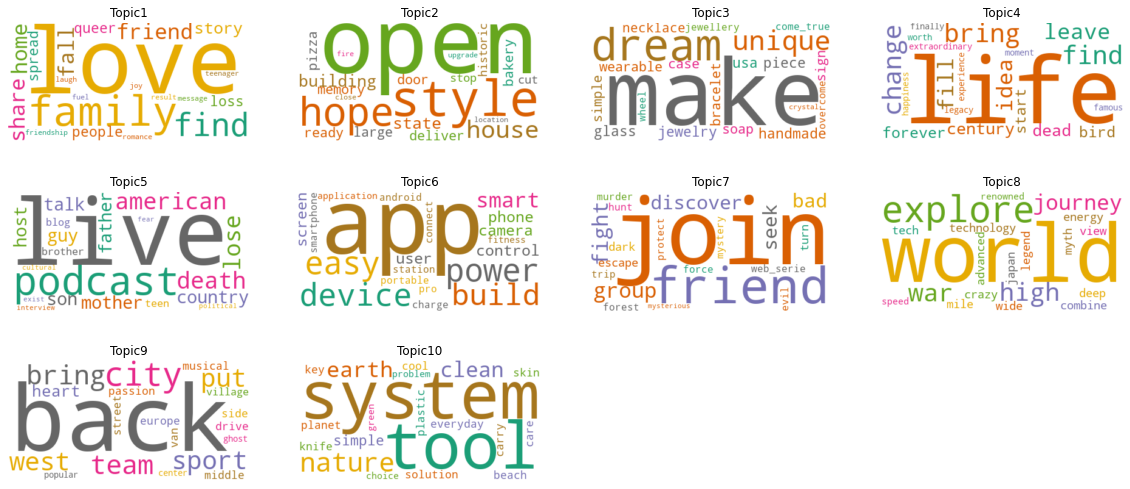

In [39]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [40]:
from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

ldagensim = convertldaMalletToldaGen(ldamallet)

In [46]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldagensim, corpus, id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.046837  0.014291  1       1        1.986629
1      0.004511  0.006737  2       1        1.994144
2     -0.277718 -0.134994  3       1        1.993873
3      0.028028  0.040843  4       1        1.986190
4      0.015839  0.018138  5       1        1.991602
5      0.005858  0.022332  6       1        2.062018
6      0.015635  0.033847  7       1        1.989486
7      0.003104  0.073126  8       1        1.997545
8      0.028950  0.022524  9       1        1.990190
9     -0.018762 -0.009464  10      1        2.002234
10    -0.055981  0.070454  11      1        2.049957
11     0.094502 -0.117713  12      1        1.985923
12    -0.246911 -0.131986  13      1        1.971269
13     0.007478  0.054367  14      1        2.013176
14    -0.012272 -0.001312  15      1        2.026245
15     0.081283 -0.135797  16      1        2.003032
16    -0.017817  0.063644  17      1        1.994171
17     0.096973 -0.062451  18      1        2.028184
18     0.003365  0.015167  19      1        1.995042
19    -0.013269  0.097112  20      1        1.983936
20    -0.006958  0.042798  21      1        2.022441
21    -0.003116  0.036124  22      1        1.984077
22    -0.042000  0.091327  23      1        2.002360
23    -0.002778  0.027091  24      1        1.979251
24     0.014052  0.073465  25      1        1.973541
25     0.006863  0.027382  26      1        1.973017
26     0.056047 -0.029929  27      1        2.053335
27    -0.004645  0.006894  28      1        1.996009
28     0.081620 -0.117238  29      1        1.972820
29    -0.005405  0.048770  30      1        1.983412
30     0.026518 -0.029911  31      1        1.983235
31    -0.000467  0.055425  32      1        2.001048
32    -0.210208 -0.168989  33      1        1.979178
33     0.001492  0.029100  34      1        1.984430
34     0.006493  0.032557  35      1        1.980532
35     0.040155  0.005027  36      1        1.979170
36     0.087060 -0.103916  37      1        1.982125
37     0.144083 -0.153733  38      1        1.985902
38    -0.009026  0.013397  39      1        2.034135
39     0.007518  0.032153  40      1        1.991113
40     0.002999  0.005978  41      1        2.056618
41     0.115899 -0.186670  42      1        1.999986
42     0.017170 -0.003165  43      1        2.014624
43    -0.018136  0.023415  44      1        2.005935
44    -0.001466  0.039583  45      1        1.999236
45     0.024321  0.012255  46      1        2.000959
46    -0.019795  0.013567  47      1        2.019333
47    -0.002641  0.054754  48      1        2.008233
48    -0.005232  0.112556  49      1        2.018406
49    -0.090051  0.071065  50      1        1.990694, topic_info=           Term         Freq        Total Category  logprob  loglift
61    make       1282.000000  1282.000000  Default  30.0000  30.0000
285   world      853.000000   853.000000   Default  29.0000  29.0000
12    book       802.000000   802.000000   Default  28.0000  28.0000
442   game       631.000000   631.000000   Default  27.0000  27.0000
37    life       588.000000   588.000000   Default  26.0000  26.0000
...    ...              ...          ...       ...      ...      ...
910   design     66.834918    582.363830   Topic50 -3.7478   1.7518 
2389  colorful   16.958115    32.235939    Topic50 -5.1192   3.2744 
229   feature    23.545618    431.129895   Topic50 -4.7910   1.0092 
455   character  17.899187    115.174071   Topic50 -5.0652   2.0550 
634   present    16.958115    93.693217    Topic50 -5.1192   2.2074 

[2224 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
517   22     0.933982  abandon
4016  37     0.644458  ability
4016  39     0.171855  ability
4016  45     0.128892  ability
4016  49     0.042964  ability
...   ..          ...      ...
5313  50     0.847969  zodiac 
3759  1      0.067524  zombie 
3759  5      0.033762  zo

### View topics and assign them to model

In [48]:
lda_model = ldamallet

#Assign Topics to documents
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


# df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [49]:
# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,21.0,0.0783,"adventure, space, modern, action, classic, journey, twist, character, sci, freedom",find happens albert decides play food takes high flying adventure outer space
1,1,11.0,0.0565,"show, create, student, reality, social, guide, college, science, interactive, platform",following success hastings leonard guide book creating sneeky peek guide rye
2,2,7.0,0.0384,"world, explore, high, war, journey, technology, legend, deep, energy, combine",join amazing journey impacting million children
3,3,0.0,0.0377,"love, family, find, friend, home, share, fall, story, people, loss",anthology queer witchery
4,4,0.0,0.0339,"love, family, find, friend, home, share, fall, story, people, loss",written chronically ill girl commenting ups downs craziness life love instability


In [50]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1416,"love, family, find, friend, home, share, fall, story, people, loss",traveling home ghibli inspired fantasy tabletop rpg queer romance found family finding healing belonging
1,1.0,0.1020,"open, style, hope, house, building, state, memory, ready, deliver, large",tiny chocolate making company found location ready open shop help open doors
2,2.0,0.1368,"make, dream, unique, jewelry, handmade, piece, usa, glass, wearable, bracelet",handmade pendant necklace choose aengus cernunnos taranis annan brigid morrígu unique wearable piece jewelry art
3,3.0,0.1453,"life, bring, change, find, leave, fill, idea, century, dead, forever",jamie loves kelli loves leslie leslie left husband kelli leave jamie leslie starts dating kelly
4,4.0,0.1385,"live, podcast, american, lose, death, country, guy, mother, talk, son",bruce bond hosts podcast host toni toni toni featuring notable guests central help show continue grow


In [51]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,21.0,"adventure, space, modern, action, classic, journey, twist, character, sci, freedom",297.0,0.0215
1.0,11.0,"show, create, student, reality, social, guide, college, science, interactive, platform",203.0,0.0147
2.0,7.0,"world, explore, high, war, journey, technology, legend, deep, energy, combine",237.0,0.0172
3.0,0.0,"love, family, find, friend, home, share, fall, story, people, loss",242.0,0.0175
4.0,0.0,"love, family, find, friend, home, share, fall, story, people, loss",273.0,0.0198


In [52]:
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1416,"love, family, find, friend, home, share, fall, story, people, loss",traveling home ghibli inspired fantasy tabletop rpg queer romance found family finding healing belonging
1,1.0,0.1020,"open, style, hope, house, building, state, memory, ready, deliver, large",tiny chocolate making company found location ready open shop help open doors
2,2.0,0.1368,"make, dream, unique, jewelry, handmade, piece, usa, glass, wearable, bracelet",handmade pendant necklace choose aengus cernunnos taranis annan brigid morrígu unique wearable piece jewelry art
3,3.0,0.1453,"life, bring, change, find, leave, fill, idea, century, dead, forever",jamie loves kelli loves leslie leslie left husband kelli leave jamie leslie starts dating kelly
4,4.0,0.1385,"live, podcast, american, lose, death, country, guy, mother, talk, son",bruce bond hosts podcast host toni toni toni featuring notable guests central help show continue grow


In [53]:
pd.set_option("display.max_colwidth", None)
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1416,"love, family, find, friend, home, share, fall, story, people, loss",traveling home ghibli inspired fantasy tabletop rpg queer romance found family finding healing belonging
1,1.0,0.1020,"open, style, hope, house, building, state, memory, ready, deliver, large",tiny chocolate making company found location ready open shop help open doors
2,2.0,0.1368,"make, dream, unique, jewelry, handmade, piece, usa, glass, wearable, bracelet",handmade pendant necklace choose aengus cernunnos taranis annan brigid morrígu unique wearable piece jewelry art
3,3.0,0.1453,"life, bring, change, find, leave, fill, idea, century, dead, forever",jamie loves kelli loves leslie leslie left husband kelli leave jamie leslie starts dating kelly
4,4.0,0.1385,"live, podcast, american, lose, death, country, guy, mother, talk, son",bruce bond hosts podcast host toni toni toni featuring notable guests central help show continue grow


In [54]:
print(len(df_dominant_topics))

13790


In [55]:
sent_topics_sorteddf_mallet.tail()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
45,45.0,0.1640,"good, online, website, medium, news, aim, develop, feel, platform, dedicated",tired getting news sources funded mega corporations newsbud people funded media media integrity matters
46,46.0,0.1658,"community, build, local, provide, farm, organic, focus, area, sustainable, urban",help fund newsweekly brewerytown fairmount francisville spring garden strawberry mansion north central ludlow poplar
47,47.0,0.1093,"art, artist, feature, creative, female, culture, include, head, visual, writer",beats brews life podcast visual series dedicated beat culture travel food creative spirit
48,48.0,0.1389,"book, comic, write, publish, page, poetry, illustrate, anthology, collection, comic_strip",sandra woo anthology features comics author commentary sketches pages art book features colored illustrations
49,49.0,0.1910,"unique, card, deck, custom, limited_edition, inspire, design, wood, box, playing_card",burlesque deck unique poker sized deck cards pin burlesque collector magician lover art cards


In [56]:
# Set index to int
df_dominant_topics = df_dominant_topics.set_index(df_dominant_topics.index.astype('int64'))
tempData['Dominant_Topic'] = df_dominant_topics['Dominant_Topic']

### Search Project to find Topic

In [57]:
## Find project index, get id
tempData.loc[tempData['name'] == "Albert's Cookie- A Children's Book"]

,name,category,blurb,Dominant_Topic
0,Albert's Cookie- A Children's Book,"{""id"":46,""name"":""Children's Books"",""slug"":""publishing/children's books"",""position"":5,""parent_id"":18,""parent_name"":""Publishing"",""color"":14867664,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/publishing/children's%20books""}}}",find happens albert decides play food takes high flying adventure outer space,21.0


In [59]:
## Find projects with similar topics 
tempData.loc[tempData['Dominant_Topic'] == 21.0]

,name,category,blurb,Dominant_Topic
0,Albert's Cookie- A Children's Book,"{""id"":46,""name"":""Children's Books"",""slug"":""publishing/children's books"",""position"":5,""parent_id"":18,""parent_name"":""Publishing"",""color"":14867664,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/publishing/children's%20books""}}}",find happens albert decides play food takes high flying adventure outer space,21.0
25,"The ""Mr. Baker's Book"" Series","{""id"":46,""name"":""Children's Books"",""slug"":""publishing/children's books"",""position"":5,""parent_id"":18,""parent_name"":""Publishing"",""color"":14867664,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/publishing/children's%20books""}}}",time traveling adventure exploring church history,21.0
80,Humans Wanted: A SF Anthology,"{""id"":324,""name"":""Anthologies"",""slug"":""publishing/anthologies"",""position"":2,""parent_id"":18,""parent_name"":""Publishing"",""color"":14867664,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/publishing/anthologies""}}}",going somewhere dangerous take human,21.0
104,The Ethereal Realms Series,"{""id"":47,""name"":""Fiction"",""slug"":""publishing/fiction"",""position"":7,""parent_id"":18,""parent_name"":""Publishing"",""color"":14867664,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/publishing/fiction""}}}",last dreamer turbulent times come ethereal realms sides chosen fae court next burn,21.0
136,Dawn,"{""id"":47,""name"":""Fiction"",""slug"":""publishing/fiction"",""position"":7,""parent_id"":18,""parent_name"":""Publishing"",""color"":14867664,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/publishing/fiction""}}}",dawn always worth waiting,21.0
...,...,...,...,...
13288,BattleFx Xenomorphs: 3D Printable Fx for insectoid Xenos,"{""id"":34,""name"":""Tabletop Games"",""slug"":""games/tabletop games"",""position"":6,""parent_id"":12,""parent_name"":""Games"",""color"":51627,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/games/tabletop%20games""}}}",pre supported stl print files take space bug army next level,21.0
13413,Farm Folks,"{""id"":35,""name"":""Video Games"",""slug"":""games/video games"",""position"":7,""parent_id"":12,""parent_name"":""Games"",""color"":51627,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/games/video%20games""}}}",farming simulator nod classic harvest moon series grow crops raise livestock build relationships,21.0
13418,Rodes Makes An Album!,"{""id"":14,""name"":""Music"",""slug"":""music"",""position"":11,""color"":10878931,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/music""}}}",rodes rodenbough working recording first full length album released spring,21.0
13482,Stoney the Sailor,"{""id"":29,""name"":""Animation"",""slug"":""film & video/animation"",""position"":2,""parent_id"":11,""parent_name"":""Film & Video"",""color"":16734574,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/film%20&%20video/animation""}}}",stoney sailor animated feature film mature audiences genre drama rated mature subject matter brief nudity,21.0


In [60]:
## Asign the groups with same topics to a new table
dfTopic = tempData.loc[tempData['Dominant_Topic'] == 21.0]

#Reset the index
dfTopic = dfTopic.reset_index()
dfTopic.head()

,index,name,category,blurb,Dominant_Topic
0,0,Albert's Cookie- A Children's Book,"{""id"":46,""name"":""Children's Books"",""slug"":""publishing/children's books"",""position"":5,""parent_id"":18,""parent_name"":""Publishing"",""color"":14867664,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/publishing/children's%20books""}}}",find happens albert decides play food takes high flying adventure outer space,21.0
1,25,"The ""Mr. Baker's Book"" Series","{""id"":46,""name"":""Children's Books"",""slug"":""publishing/children's books"",""position"":5,""parent_id"":18,""parent_name"":""Publishing"",""color"":14867664,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/publishing/children's%20books""}}}",time traveling adventure exploring church history,21.0
2,80,Humans Wanted: A SF Anthology,"{""id"":324,""name"":""Anthologies"",""slug"":""publishing/anthologies"",""position"":2,""parent_id"":18,""parent_name"":""Publishing"",""color"":14867664,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/publishing/anthologies""}}}",going somewhere dangerous take human,21.0
3,104,The Ethereal Realms Series,"{""id"":47,""name"":""Fiction"",""slug"":""publishing/fiction"",""position"":7,""parent_id"":18,""parent_name"":""Publishing"",""color"":14867664,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/publishing/fiction""}}}",last dreamer turbulent times come ethereal realms sides chosen fae court next burn,21.0
4,136,Dawn,"{""id"":47,""name"":""Fiction"",""slug"":""publishing/fiction"",""position"":7,""parent_id"":18,""parent_name"":""Publishing"",""color"":14867664,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/publishing/fiction""}}}",dawn always worth waiting,21.0


## Recommender (TF-IDF) Based on same topics

Preprocess text

In [61]:
#preprocess text
def extract_cat(text):
    text = text.split(",")
    
    text = text[1] + " " +text[2]
    

    text = text.replace ("/", " ")
    
    
    text = text.replace ("name", "")
    text = text.replace ("slug", "")
    
    text = text.replace ('"', "")
    text = text.replace ('{', "")
    text = text.replace (':', "")
    
    text = text.lower()
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text) # matches all whitespace characters
    text = text.strip(' ')
    return text



dfTopic['category'] = dfTopic['category'].apply(lambda x: extract_cat(x))

In [62]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


dfTopic['blurb']=dfTopic['blurb'].map(lambda s:preprocess(s)) 
dfTopic.head()

,index,name,category,blurb,Dominant_Topic
0,0,Albert's Cookie- A Children's Book,children's books publishing children's books,find happens albert decides play food takes high flying adventure outer space,21.0
1,25,"The ""Mr. Baker's Book"" Series",children's books publishing children's books,time traveling adventure exploring church history,21.0
2,80,Humans Wanted: A SF Anthology,anthologies publishing anthologies,going somewhere dangerous take human,21.0
3,104,The Ethereal Realms Series,fiction publishing fiction,last dreamer turbulent times come ethereal realms sides chosen fae court next burn,21.0
4,136,Dawn,fiction publishing fiction,dawn always worth waiting,21.0


In [63]:
#Keep relevant cols
dfTopic = dfTopic[['name','category','blurb']]
dfTopic.head()

,name,category,blurb
0,Albert's Cookie- A Children's Book,children's books publishing children's books,find happens albert decides play food takes high flying adventure outer space
1,"The ""Mr. Baker's Book"" Series",children's books publishing children's books,time traveling adventure exploring church history
2,Humans Wanted: A SF Anthology,anthologies publishing anthologies,going somewhere dangerous take human
3,The Ethereal Realms Series,fiction publishing fiction,last dreamer turbulent times come ethereal realms sides chosen fae court next burn
4,Dawn,fiction publishing fiction,dawn always worth waiting


Tokenize the words

In [64]:
import numpy as np
import pandas as pd
from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import re, nltk, spacy, gensim
from nltk.tokenize import ToktokTokenizer
from nltk.stem import wordnet
from nltk.corpus import stopwords
from string import punctuation


dfTopic['category_processed'] = ""


for index, row in dfTopic.iterrows():
    cat = row['category']
    
    # instantiating a Rake object
    # by default it uses english stopwords from NLTK (natural language tool kit)
    # and discards all puntuation characters
    r = Rake()

    # extracting the keywords from the text by passing plot 
    r.extract_keywords_from_text(cat)

    # getting the dictionary whith key words and their scores
    key_words_dict_scorestwo = r.get_word_degrees()
    
    # assigning the key words to the new column
    row['category_processed'] = [w for w in key_words_dict_scorestwo.keys()]

In [65]:
dfTopic['blurb_processed'] = ""

for index, row in dfTopic.iterrows():
    desc = row['blurb']
    
    # instantiating a Rake object
    # by default it uses english stopwords from NLTK (natural language tool kit)
    # and discards all puntuation characters
    r = Rake()

    # extracting the keywords from the text by passing plot 
    r.extract_keywords_from_text(str(desc))

    # getting the dictionary whith key words and their scores
    key_words_dict_scores = r.get_word_degrees()
    
    # assigning the key words to the new column
    #stemming
#     row['desc_stem'] = [stemmer.stem(w) for w in key_words_dict_scores.keys()]
    row['blurb_processed'] = [w for w in key_words_dict_scores.keys()]

In [66]:
dfTopic = dfTopic[['name', 'category_processed', 'blurb_processed']]

dfTopic.head()

,name,category_processed,blurb_processed
0,Albert's Cookie- A Children's Book,"[children, books, publishing]","[find, happens, albert, decides, play, food, takes, high, flying, adventure, outer, space]"
1,"The ""Mr. Baker's Book"" Series","[children, books, publishing]","[time, traveling, adventure, exploring, church, history]"
2,Humans Wanted: A SF Anthology,"[anthologies, publishing]","[going, somewhere, dangerous, take, human]"
3,The Ethereal Realms Series,"[fiction, publishing]","[last, dreamer, turbulent, times, come, ethereal, realms, sides, chosen, fae, court, next, burn]"
4,Dawn,"[fiction, publishing]","[dawn, always, worth, waiting]"


In [67]:
# create bag of words with cat and blurb
columns = dfTopic.columns[1:]


dfTopic['bag_of_words'] = ''

for index, row in dfTopic.iterrows():
    words = ''
    for col in columns:
        if col != 'bag_of_words':
            # to convert the list into a string of words separated by a space
            words = words + ' '.join(row[col])+ ' '
        else:
            words = words + row[col]+ ' '
    row['bag_of_words'] = words

# let's keep only the title and the bag of words in the dataframe
dfTopic.head()

,name,category_processed,blurb_processed,bag_of_words
0,Albert's Cookie- A Children's Book,"[children, books, publishing]","[find, happens, albert, decides, play, food, takes, high, flying, adventure, outer, space]",children books publishing find happens albert decides play food takes high flying adventure outer space
1,"The ""Mr. Baker's Book"" Series","[children, books, publishing]","[time, traveling, adventure, exploring, church, history]",children books publishing time traveling adventure exploring church history
2,Humans Wanted: A SF Anthology,"[anthologies, publishing]","[going, somewhere, dangerous, take, human]",anthologies publishing going somewhere dangerous take human
3,The Ethereal Realms Series,"[fiction, publishing]","[last, dreamer, turbulent, times, come, ethereal, realms, sides, chosen, fae, court, next, burn]",fiction publishing last dreamer turbulent times come ethereal realms sides chosen fae court next burn
4,Dawn,"[fiction, publishing]","[dawn, always, worth, waiting]",fiction publishing dawn always worth waiting


In [68]:
# instantiating and generating the count matrix using CountVectorizer
count = CountVectorizer()
count_matrix = count.fit_transform(dfTopic['bag_of_words'])

In [69]:
# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)

[[1.         0.34426519 0.09759001 ... 0.         0.         0.        ]
 [0.34426519 1.         0.12598816 ... 0.         0.         0.10050378]
 [0.09759001 0.12598816 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.34585723]
 [0.         0.10050378 0.         ... 0.         0.34585723 1.        ]]


In [70]:
indices = pd.Series(dfTopic['name'])
indices[:5]
dfTopic = dfTopic[['name', 'bag_of_words']]

dfTopic.head()

,name,bag_of_words
0,Albert's Cookie- A Children's Book,children books publishing find happens albert decides play food takes high flying adventure outer space
1,"The ""Mr. Baker's Book"" Series",children books publishing time traveling adventure exploring church history
2,Humans Wanted: A SF Anthology,anthologies publishing going somewhere dangerous take human
3,The Ethereal Realms Series,fiction publishing last dreamer turbulent times come ethereal realms sides chosen fae court next burn
4,Dawn,fiction publishing dawn always worth waiting


In [71]:
def recommendations(name, cosine_sim = cosine_sim):
    
    recommended = []
    
    # getting the index with the given title
    idx = indices[indices == name].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar 
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching
    for i in top_10_indexes:
        recommended.append(list(dfTopic['name'])[i])
        
    return recommended

In [73]:
recommendations("Albert's Cookie- A Children's Book")

['The "Mr. Baker\'s Book" Series',
 'Joaquin and the Pekkybirds, A Brooklyn Story',
 'Being different is ok!',
 "Josh Kirby's Marmaduke Mousington - Children's Book",
 'A Frequent Flyer - The Road to Publication',
 'Our President Was Called Barack—A "Yes We Can" Book for Kids',
 'Lucky & The Night Runners - A Novel Co-Created With Kids',
 'Jungle Ship',
 'Unnati Manz Biotec Dairy Farms Pvt Ltd',
 "Letbia's Cookbook: Authentic Mexican & International Cuisine"]